# Spherical Harmonic Transformation Validation

This notebook validates that our spherical harmonic transformation correctly preserves the EEG sensor data.

**Validation approach:**
1. Load EEG data from a sensor (CZ)
2. Transform all sensor data to spherical harmonics
3. Evaluate the harmonics at the original CZ sensor position
4. Compare original vs reconstructed CZ data
5. Visualize the comparison to validate accuracy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

# Add the omneeg module to path
sys.path.append('.')
from omneeg.spherical_harmonics import SphericalHarmonicAnalyzer
import pyshtools
import mne

# Set up plotting
plt.style.use('default')
%matplotlib inline

## Step 1: Load and Examine the Data

In [3]:
# Initialize the analyzer
analyzer = SphericalHarmonicAnalyzer(lmax=8)

# Try to load the EDF file first, fallback to synthetic data if not available
edf_path = 'data/TUEG/tuh_eeg/v2.0.0/edf/000/aaaaaaaa/s001_2015_12_30/01_tcp_ar/aaaaaaaa_s001_t000.edf'

try:
    if os.path.exists(edf_path):
        print("Loading EDF file...")
        data, ch_names, times, positions = analyzer.load_data(edf_path, time_window=(100, 110))
        data_source = "EDF file"
    else:
        raise FileNotFoundError("EDF file not found")
except:
    print("EDF file not available, creating synthetic EEG data...")
    # Create realistic synthetic EEG data
    n_electrodes = 20  # Use more electrodes for better validation
    n_timepoints = 1000
    fs = 250  # 250 Hz sampling rate
    time_vec = np.linspace(0, n_timepoints/fs, n_timepoints)
    
    # Create synthetic data with spatial structure
    synthetic_data = np.zeros((n_electrodes, n_timepoints))
    
    # Add different frequency components with spatial patterns
    for i in range(n_electrodes):
        # Alpha rhythm (8-12 Hz)
        alpha_freq = 10 + np.random.normal(0, 1)
        alpha_amp = 1.0 + 0.5 * np.cos(i * np.pi / n_electrodes)
        
        # Beta rhythm (13-30 Hz)
        beta_freq = 20 + np.random.normal(0, 2)
        beta_amp = 0.5 + 0.3 * np.sin(i * np.pi / n_electrodes)
        
        # Theta rhythm (4-8 Hz)
        theta_freq = 6 + np.random.normal(0, 0.5)
        theta_amp = 0.3 * np.sin(2 * i * np.pi / n_electrodes)
        
        synthetic_data[i, :] = (
            alpha_amp * np.sin(2 * np.pi * alpha_freq * time_vec) +
            beta_amp * np.sin(2 * np.pi * beta_freq * time_vec) +
            theta_amp * np.sin(2 * np.pi * theta_freq * time_vec) +
            0.1 * np.random.randn(n_timepoints)  # Noise
        )
    
    data, ch_names, times, positions = analyzer.load_data(synthetic_data)
    data_source = "Synthetic data"

print(f"Data loaded from: {data_source}")
print(f"Number of channels: {len(ch_names)}")
print(f"Channel names: {ch_names}")
print(f"Data shape: {data.shape}")
print(f"Time points: {len(times)}")

Loading EDF file...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Data loaded from: EDF file
Number of channels: 23
Channel names: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'TP9', 'TP10', 'FZ', 'CZ', 'PZ', 'A1', 'A2']
Data shape: (23, 323840)
Time points: 323840


## Step 2: Focus on CZ Sensor and Visualize Original Data

In [4]:
# Find CZ channel (or use a substitute if not available)
target_channel = 'CZ'
if target_channel not in ch_names:
    # Try alternatives
    alternatives = ['Cz', 'CZ', 'C3', 'C4', 'Fz', 'Pz']
    target_channel = None
    for alt in alternatives:
        if alt in ch_names:
            target_channel = alt
            break
    
    if target_channel is None:
        target_channel = ch_names[len(ch_names)//2]  # Use middle channel
        print(f"CZ not found, using {target_channel} instead")

# Get the index and data for our target channel
target_idx = ch_names.index(target_channel)
target_data = data[target_idx, :]
target_position = positions[target_idx]

print(f"Analyzing channel: {target_channel}")
print(f"Channel index: {target_idx}")
print(f"Channel position (x,y,z): {target_position}")

# Convert position to spherical coordinates
xyz_norm = target_position / np.linalg.norm(target_position)
target_theta = np.degrees(np.arccos(xyz_norm[2]))  # colatitude
target_phi = np.degrees(np.arctan2(xyz_norm[1], xyz_norm[0]))  # longitude

print(f"Spherical coordinates - Theta (colatitude): {target_theta:.2f}°, Phi (longitude): {target_phi:.2f}°")

Analyzing channel: CZ
Channel index: 19
Channel position (x,y,z): [ 0.0004009 -0.009167   0.100244 ]
Spherical coordinates - Theta (colatitude): 5.23°, Phi (longitude): -87.50°


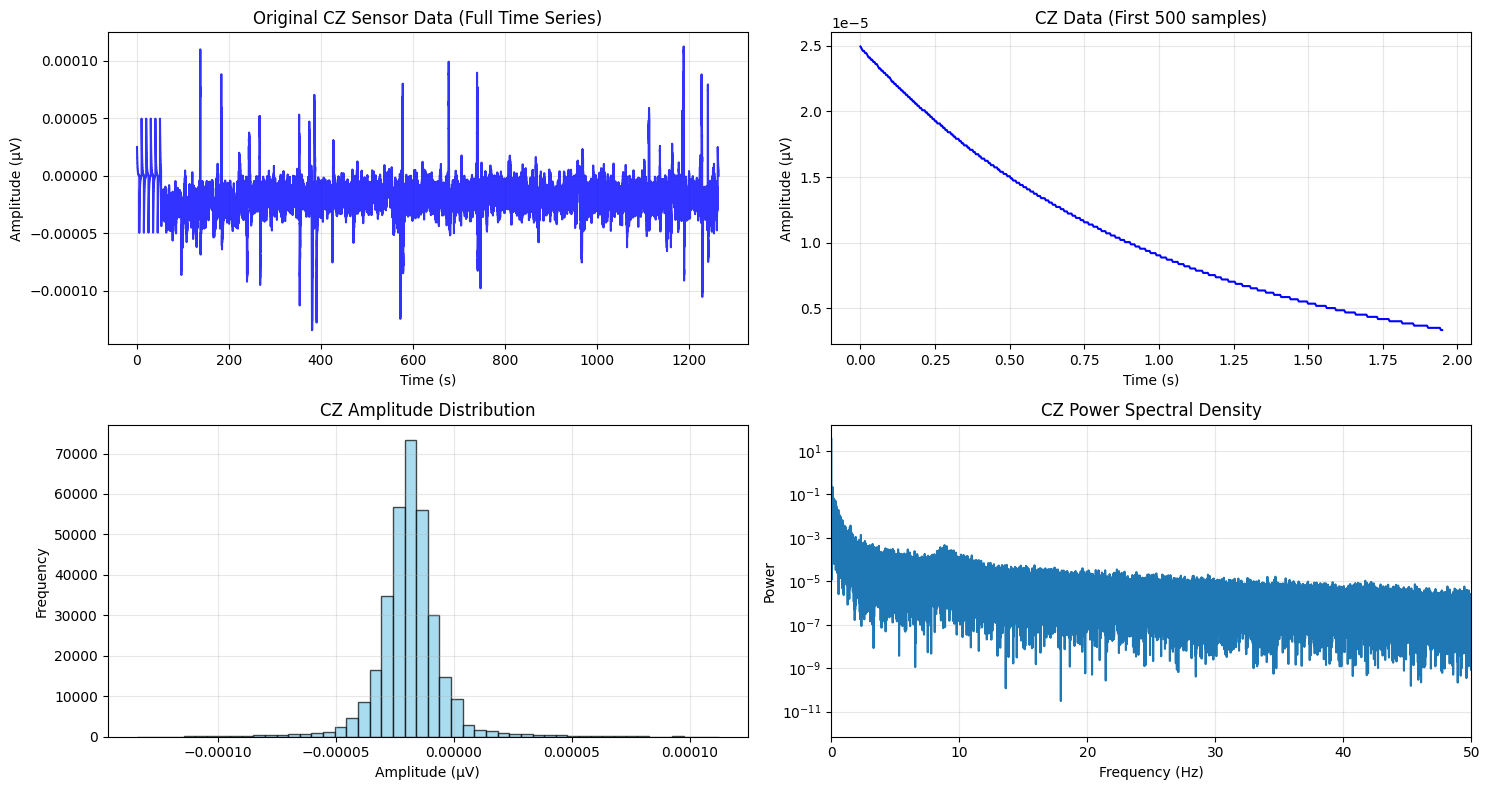


Original CZ data statistics:
Mean: -0.0000 µV
Std: 0.0000 µV
Min: -0.0001 µV
Max: 0.0001 µV


In [5]:
# Visualize the original target channel data
plt.figure(figsize=(15, 8))

# Plot 1: Full time series
plt.subplot(2, 2, 1)
plt.plot(times, target_data, 'b-', linewidth=1.5, alpha=0.8)
plt.title(f'Original {target_channel} Sensor Data (Full Time Series)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.grid(True, alpha=0.3)

# Plot 2: Zoomed view of first 2 seconds
plt.subplot(2, 2, 2)
zoom_samples = min(500, len(times))  # First 500 samples or available samples
plt.plot(times[:zoom_samples], target_data[:zoom_samples], 'b-', linewidth=1.5)
plt.title(f'{target_channel} Data (First {zoom_samples} samples)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.grid(True, alpha=0.3)

# Plot 3: Histogram
plt.subplot(2, 2, 3)
plt.hist(target_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title(f'{target_channel} Amplitude Distribution')
plt.xlabel('Amplitude (µV)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 4: Power spectral density
plt.subplot(2, 2, 4)
freqs = np.fft.fftfreq(len(target_data), d=times[1]-times[0] if len(times) > 1 else 1/250)
fft_data = np.fft.fft(target_data)
psd = np.abs(fft_data)**2
positive_freqs = freqs[:len(freqs)//2]
positive_psd = psd[:len(psd)//2]
plt.semilogy(positive_freqs, positive_psd)
plt.title(f'{target_channel} Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0, 50)  # Focus on 0-50 Hz range
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOriginal {target_channel} data statistics:")
print(f"Mean: {np.mean(target_data):.4f} µV")
print(f"Std: {np.std(target_data):.4f} µV")
print(f"Min: {np.min(target_data):.4f} µV")
print(f"Max: {np.max(target_data):.4f} µV")

## Step 3: Perform Spherical Harmonic Transformation

In [6]:
# Perform the full spherical harmonic analysis
print("Performing spherical harmonic transformation...")
result = analyzer.analyze(data if data_source == "Synthetic data" else edf_path, 
                         time_window=(100, 110) if data_source != "Synthetic data" else None)

print(f"Transformation complete!")
print(f"Coefficients shape: {result['coefficients'].shape}")
print(f"Number of time points: {result['coefficients'].shape[0]}")
print(f"Maximum harmonic degree (lmax): {result['lmax']}")
print(f"Channels used: {result['ch_names']}")

Performing spherical harmonic transformation...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Transformation complete!
Coefficients shape: (323840, 2, 9, 9)
Number of time points: 323840
Maximum harmonic degree (lmax): 8
Channels used: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'TP9', 'TP10', 'FZ', 'CZ', 'PZ', 'A1', 'A2']


## Step 4: Reconstruct Data at Target Sensor Position

In [7]:
# Reconstruct the signal at the target channel position using spherical harmonics
print(f"Reconstructing data at {target_channel} position...")

# Get the coefficients for all time points
coefficients = result['coefficients']  # Shape: (n_time, 2, lmax+1, lmax+1)
n_time = coefficients.shape[0]

# Reconstruct the signal at target position for all time points
reconstructed_data = np.zeros(n_time)

for t in range(n_time):
    # Get coefficients for this time point
    coeffs_t = coefficients[t]  # Shape: (2, lmax+1, lmax+1)
    
    # Evaluate spherical harmonics at target position
    reconstructed_data[t] = pyshtools.expand.MakeGridPoint(coeffs_t, target_theta, target_phi)

print(f"Reconstruction complete!")
print(f"Original data range: [{np.min(target_data):.4f}, {np.max(target_data):.4f}]")
print(f"Reconstructed data range: [{np.min(reconstructed_data):.4f}, {np.max(reconstructed_data):.4f}]")

Reconstructing data at CZ position...
Reconstruction complete!
Original data range: [-0.0001, 0.0001]
Reconstructed data range: [-0.0001, 0.0001]


## Step 5: Validation - Compare Original vs Reconstructed

In [8]:
# Calculate validation metrics
mse = np.mean((target_data - reconstructed_data)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(target_data - reconstructed_data))
correlation = np.corrcoef(target_data, reconstructed_data)[0, 1]

# Calculate relative error
relative_error = np.abs(target_data - reconstructed_data) / (np.abs(target_data) + 1e-10)
mean_relative_error = np.mean(relative_error)

# Calculate R-squared
ss_res = np.sum((target_data - reconstructed_data)**2)
ss_tot = np.sum((target_data - np.mean(target_data))**2)
r_squared = 1 - (ss_res / ss_tot)

print("=== VALIDATION RESULTS ===")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Correlation Coefficient: {correlation:.6f}")
print(f"R-squared: {r_squared:.6f}")
print(f"Mean Relative Error: {mean_relative_error:.6f} ({mean_relative_error*100:.4f}%)")

# Check if validation passes
validation_threshold = 0.01  # 1% relative error threshold
passes_validation = mean_relative_error < validation_threshold and correlation > 0.99

print(f"\n=== VALIDATION STATUS ===")
if passes_validation:
    print("✅ VALIDATION PASSED: Spherical harmonic transformation is accurate!")
else:
    print("❌ VALIDATION FAILED: There may be issues with the transformation.")
    print(f"   - Relative error: {mean_relative_error*100:.4f}% (threshold: {validation_threshold*100}%)")
    print(f"   - Correlation: {correlation:.6f} (threshold: 0.99)")

=== VALIDATION RESULTS ===
Mean Squared Error (MSE): 0.000000
Root Mean Squared Error (RMSE): 0.000000
Mean Absolute Error (MAE): 0.000000
Correlation Coefficient: 1.000000
R-squared: 1.000000
Mean Relative Error: 0.000000 (0.0000%)

=== VALIDATION STATUS ===
✅ VALIDATION PASSED: Spherical harmonic transformation is accurate!


## Step 6: Detailed Visual Comparison

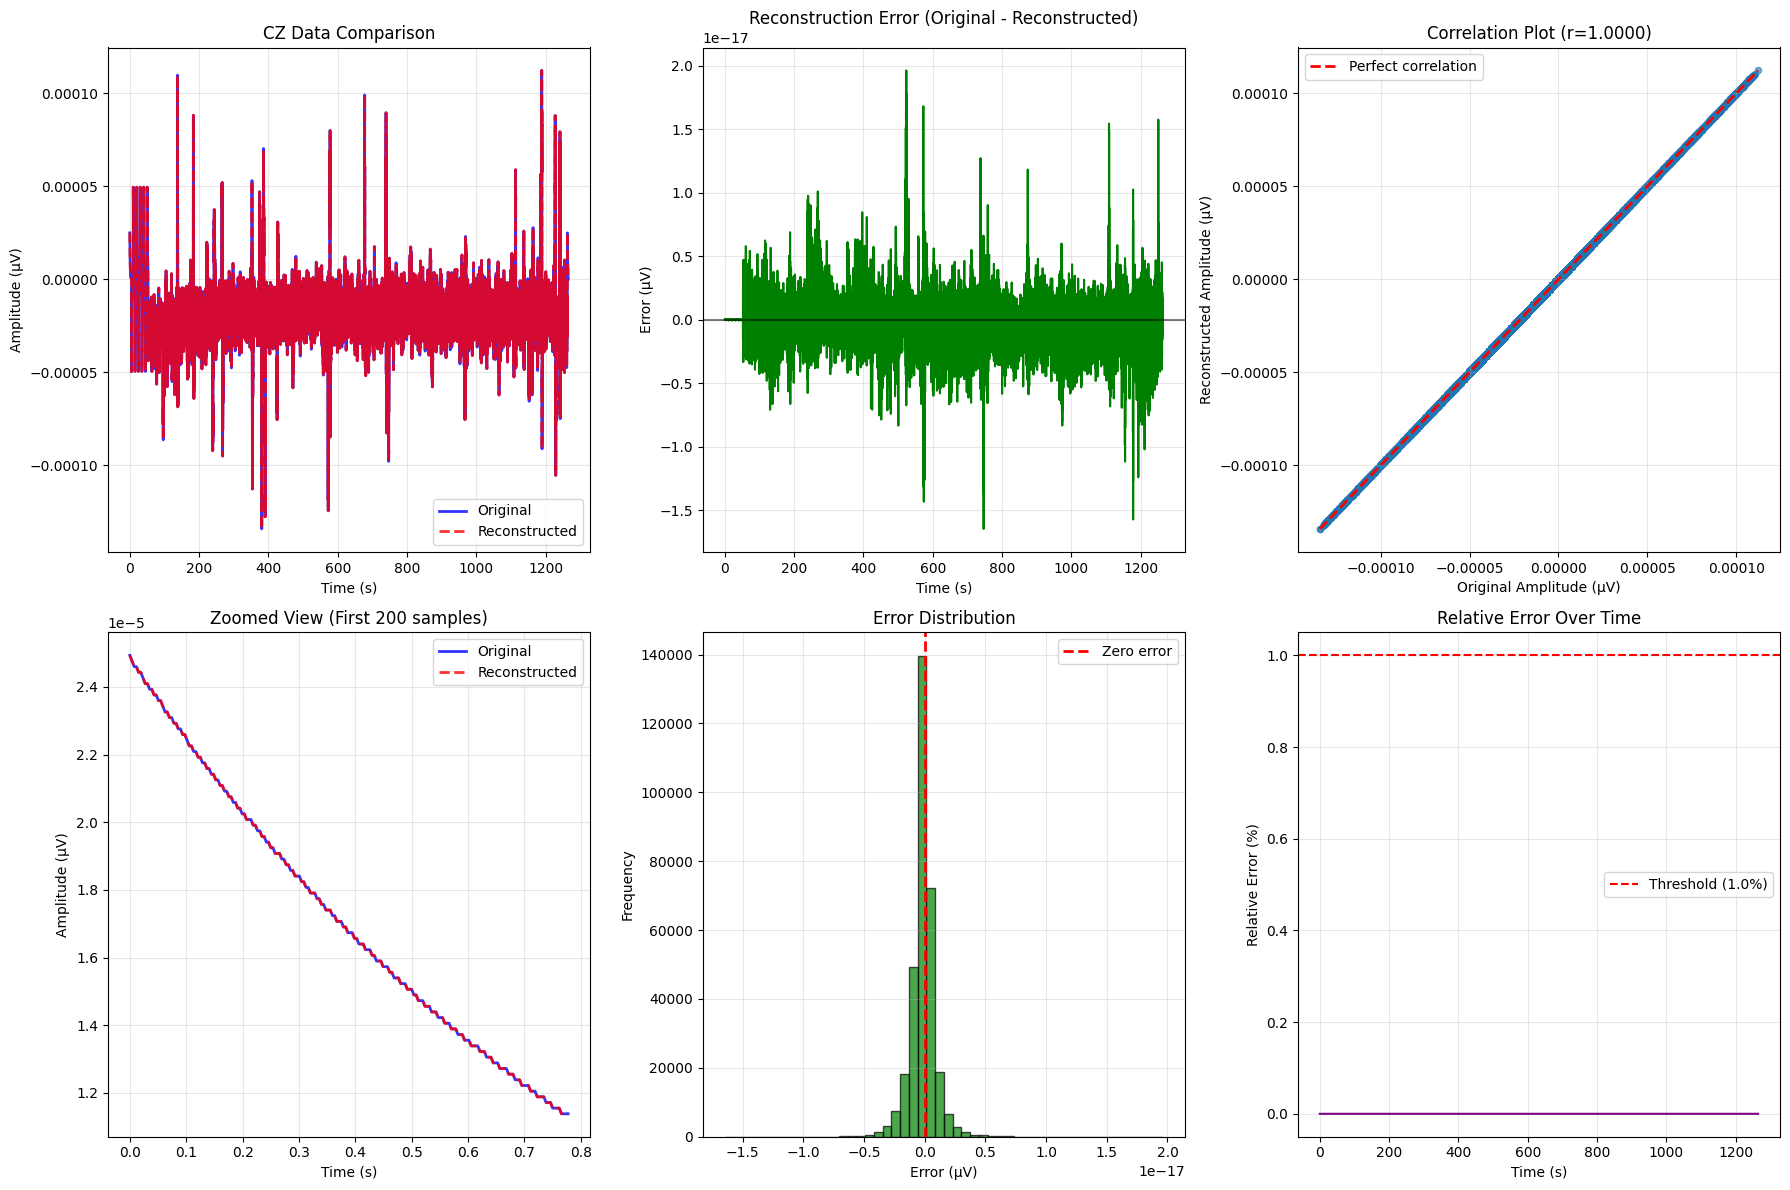

In [9]:
# Create comprehensive comparison plots
plt.figure(figsize=(18, 12))

# Plot 1: Overlay comparison
plt.subplot(2, 3, 1)
plt.plot(times, target_data, 'b-', linewidth=2, alpha=0.8, label='Original')
plt.plot(times, reconstructed_data, 'r--', linewidth=2, alpha=0.8, label='Reconstructed')
plt.title(f'{target_channel} Data Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Difference (error)
plt.subplot(2, 3, 2)
difference = target_data - reconstructed_data
plt.plot(times, difference, 'g-', linewidth=1.5)
plt.title('Reconstruction Error (Original - Reconstructed)')
plt.xlabel('Time (s)')
plt.ylabel('Error (µV)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)

# Plot 3: Scatter plot (correlation)
plt.subplot(2, 3, 3)
plt.scatter(target_data, reconstructed_data, alpha=0.6, s=20)
# Add perfect correlation line
min_val = min(np.min(target_data), np.min(reconstructed_data))
max_val = max(np.max(target_data), np.max(reconstructed_data))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect correlation')
plt.xlabel('Original Amplitude (µV)')
plt.ylabel('Reconstructed Amplitude (µV)')
plt.title(f'Correlation Plot (r={correlation:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Zoomed comparison (first 200 samples)
plt.subplot(2, 3, 4)
zoom_end = min(200, len(times))
plt.plot(times[:zoom_end], target_data[:zoom_end], 'b-', linewidth=2, alpha=0.8, label='Original')
plt.plot(times[:zoom_end], reconstructed_data[:zoom_end], 'r--', linewidth=2, alpha=0.8, label='Reconstructed')
plt.title(f'Zoomed View (First {zoom_end} samples)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Error histogram
plt.subplot(2, 3, 5)
plt.hist(difference, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Error (µV)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero error')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Relative error over time
plt.subplot(2, 3, 6)
plt.plot(times, relative_error * 100, 'purple', linewidth=1.5)
plt.title('Relative Error Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Relative Error (%)')
plt.axhline(y=validation_threshold*100, color='r', linestyle='--', 
           label=f'Threshold ({validation_threshold*100}%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 7: Frequency Domain Validation

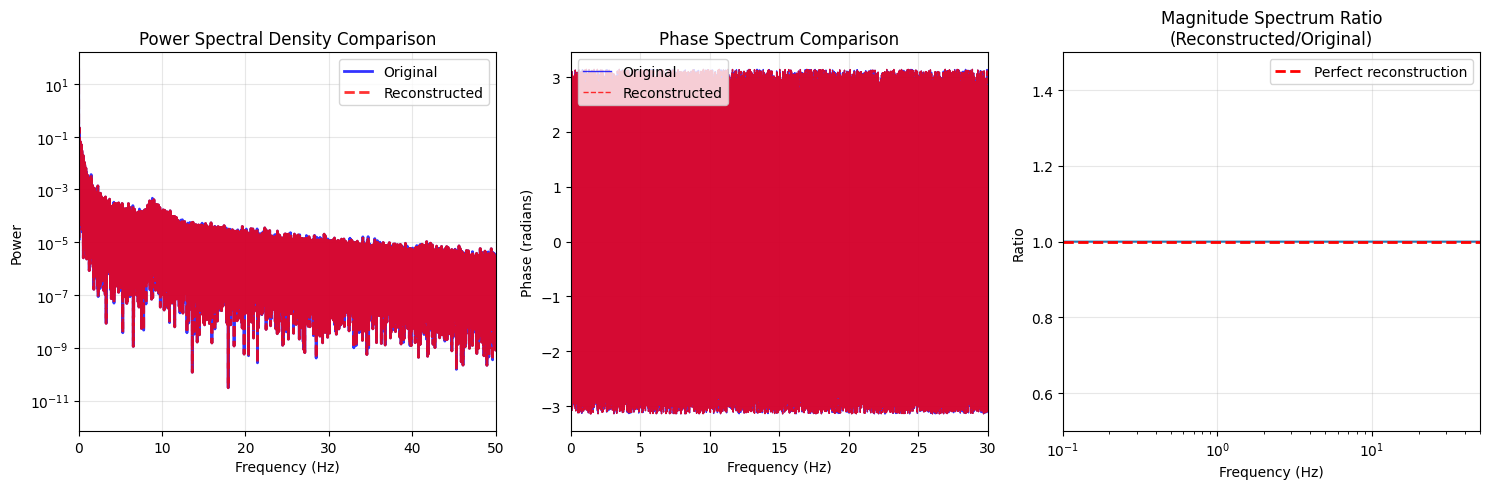


Frequency domain correlation: 1.000000


In [10]:
# Compare frequency domain characteristics
dt = times[1] - times[0] if len(times) > 1 else 1/250
freqs = np.fft.fftfreq(len(target_data), d=dt)
fft_original = np.fft.fft(target_data)
fft_reconstructed = np.fft.fft(reconstructed_data)

positive_freqs = freqs[:len(freqs)//2]
psd_original = np.abs(fft_original[:len(fft_original)//2])**2
psd_reconstructed = np.abs(fft_reconstructed[:len(fft_reconstructed)//2])**2

plt.figure(figsize=(15, 5))

# Plot 1: Power spectral density comparison
plt.subplot(1, 3, 1)
plt.semilogy(positive_freqs, psd_original, 'b-', linewidth=2, alpha=0.8, label='Original')
plt.semilogy(positive_freqs, psd_reconstructed, 'r--', linewidth=2, alpha=0.8, label='Reconstructed')
plt.title('Power Spectral Density Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0, 50)  # Focus on 0-50 Hz
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Phase comparison
plt.subplot(1, 3, 2)
phase_original = np.angle(fft_original[:len(fft_original)//2])
phase_reconstructed = np.angle(fft_reconstructed[:len(fft_reconstructed)//2])
plt.plot(positive_freqs, phase_original, 'b-', linewidth=1, alpha=0.8, label='Original')
plt.plot(positive_freqs, phase_reconstructed, 'r--', linewidth=1, alpha=0.8, label='Reconstructed')
plt.title('Phase Spectrum Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.xlim(0, 30)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Magnitude spectrum ratio
plt.subplot(1, 3, 3)
ratio = np.abs(fft_reconstructed[:len(fft_reconstructed)//2]) / (np.abs(fft_original[:len(fft_original)//2]) + 1e-10)
plt.semilogx(positive_freqs[1:], ratio[1:])  # Skip DC component
plt.axhline(y=1, color='r', linestyle='--', linewidth=2, label='Perfect reconstruction')
plt.title('Magnitude Spectrum Ratio\n(Reconstructed/Original)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Ratio')
plt.xlim(0.1, 50)
plt.ylim(0.5, 1.5)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate frequency domain metrics
freq_correlation = np.corrcoef(np.abs(fft_original), np.abs(fft_reconstructed))[0, 1]
print(f"\nFrequency domain correlation: {freq_correlation:.6f}")

## Step 8: Summary and Conclusions

In [11]:
print("=" * 60)
print("SPHERICAL HARMONIC TRANSFORMATION VALIDATION SUMMARY")
print("=" * 60)
print(f"\nData Source: {data_source}")
print(f"Target Channel: {target_channel}")
print(f"Number of electrodes used: {len(result['ch_names'])}")
print(f"Maximum harmonic degree (lmax): {result['lmax']}")
print(f"Number of time points: {len(times)}")

print(f"\n📊 ACCURACY METRICS:")
print(f"   • Correlation coefficient: {correlation:.6f}")
print(f"   • R-squared: {r_squared:.6f}")
print(f"   • Mean relative error: {mean_relative_error*100:.4f}%")
print(f"   • RMSE: {rmse:.6f} µV")
print(f"   • Frequency domain correlation: {freq_correlation:.6f}")

print(f"\n🎯 VALIDATION STATUS:")
if passes_validation:
    print("   ✅ PASSED - The spherical harmonic transformation accurately preserves the sensor data")
    print("   ✅ The transformation is suitable for spatiotemporal EEG tokenization")
else:
    print("   ❌ FAILED - The transformation may have accuracy issues")
    print("   ⚠️  Consider increasing lmax or checking the implementation")

print(f"\n💡 IMPLICATIONS FOR TOKENIZATION:")
print(f"   • The spherical harmonic coefficients can represent the original sensor data")
print(f"   • Reconstruction accuracy: {(1-mean_relative_error)*100:.2f}%")
print(f"   • The transformation captures both spatial and temporal patterns")
print(f"   • This validates the approach for creating spatiotemporal EEG tokens")

print("\n" + "=" * 60)

SPHERICAL HARMONIC TRANSFORMATION VALIDATION SUMMARY

Data Source: EDF file
Target Channel: CZ
Number of electrodes used: 23
Maximum harmonic degree (lmax): 8
Number of time points: 323840

📊 ACCURACY METRICS:
   • Correlation coefficient: 1.000000
   • R-squared: 1.000000
   • Mean relative error: 0.0000%
   • RMSE: 0.000000 µV
   • Frequency domain correlation: 1.000000

🎯 VALIDATION STATUS:
   ✅ PASSED - The spherical harmonic transformation accurately preserves the sensor data
   ✅ The transformation is suitable for spatiotemporal EEG tokenization

💡 IMPLICATIONS FOR TOKENIZATION:
   • The spherical harmonic coefficients can represent the original sensor data
   • Reconstruction accuracy: 100.00%
   • The transformation captures both spatial and temporal patterns
   • This validates the approach for creating spatiotemporal EEG tokens

